# Predicting Fraudulent Bank Transactions

Using historical bank data, I have developed a prediction model to identify potential fraudulent bank transactions (i.e. payments) made by customers to various merchants in North Carolina (zip: 28007).

Although this model is built on payment data for a specified location and contains fields (e.g. gender) that may not readily be available in other transactional datasets, a similar model can be built for various types of electronic/ACH, credit card, online, P2P transactions, etc.

The data was extracted from a Kaggle contributor: https://www.kaggle.com/turkayavci


In [3]:
#import the necessary libraries

import numpy as np
import pandas as pd
import xlrd
import os
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, VotingClassifier, StackingRegressor, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import requests
from bs4 import BeautifulSoup
import pandas as pd

!pip install thefuzz
from thefuzz import fuzz, process

C:\Users\alira\Anaconda3\envs\learn-env\lib\site-packages\thefuzz\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## 1. EDA: Exploratory Data Analysis

In [4]:
bankdata_df = pd.read_csv("./bs140513_032310_csv.csv")
bankdata_df.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


_Step:_ This feature represents the day from the start of the data aggregation. It covers a period of 6 months.

_Customer:_ Customer id

_zipCodeOrigin:_ The zip code of origin/source.

_Merchant:_ The merchant id

_zipMerchant:_ The merchant zip code

_Age:_ Categorized age
0: <= 18,
1: 19-25,
2: 26-35,
3: 36-45,
4: 46:55,
5: 56:65,
6: > 65
U: Unknown

_Gender:_ 
E : Enterprise
F: Female
M: Male
U: Unknown

_Category:_ Category of the purchase

_Amount:_ Amount of the purchase

_Fraud:_ Target - fraudulent(1) or not(0)

In [5]:
bankdata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [6]:
bankdata_df['fraud'].value_counts(normalize=True)

0    0.987892
1    0.012108
Name: fraud, dtype: float64

In [7]:
bankdata_df['fraud'].value_counts()

0    587443
1      7200
Name: fraud, dtype: int64

We can see that only 1.2%, or 7200, of the payments were identified as being fraudulent. This is a clear imbalanced dataset which I will have to address prior to building a predictive model.

In [66]:
bankdata_df.groupby('category')['amount'].sum()

category
'es_barsandrestaurants'    2.769770e+05
'es_contents'              3.942460e+04
'es_fashion'               4.238125e+05
'es_food'                  9.732464e+05
'es_health'                2.187980e+06
'es_home'                  3.290223e+05
'es_hotelservices'         3.585913e+05
'es_hyper'                 2.803276e+05
'es_leisure'               1.441667e+05
'es_otherservices'         1.239240e+05
'es_sportsandtoys'         8.632925e+05
'es_tech'                  2.866466e+05
'es_transportation'        1.361709e+07
'es_travel'                1.638298e+06
'es_wellnessandbeauty'     9.883023e+05
Name: amount, dtype: float64

In [68]:
bankdata_df[bankdata_df['fraud']== 1].groupby('category')['amount','fraud'].sum()

<ipython-input-68-9ed6e3541204>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bankdata_df[bankdata_df['fraud']== 1].groupby('category')['amount','fraud'].sum()


,amount,fraud
category,,
'es_barsandrestaurants',19691.12,120
'es_fashion',28652.95,116
'es_health',690325.15,1696
'es_home',138160.42,302
'es_hotelservices',231159.19,548
'es_hyper',47391.52,280
'es_leisure',142335.98,474
'es_otherservices',72155.07,228
'es_sportsandtoys',684517.02,1982


In [69]:
bankdata_df[bankdata_df['fraud']== 1].groupby('category')['amount'].mean()

category
'es_barsandrestaurants'     164.092667
'es_fashion'                247.008190
'es_health'                 407.031338
'es_home'                   457.484834
'es_hotelservices'          421.823339
'es_hyper'                  169.255429
'es_leisure'                300.286878
'es_otherservices'          316.469605
'es_sportsandtoys'          345.366811
'es_tech'                   415.274114
'es_travel'                2660.802872
'es_wellnessandbeauty'      229.422535
Name: amount, dtype: float64

In [9]:
bankdata_df[bankdata_df['fraud']== 0].groupby('category')['amount'].mean()

category
'es_barsandrestaurants'     41.145997
'es_contents'               44.547571
'es_fashion'                62.347674
'es_food'                   37.070405
'es_health'                103.737228
'es_home'                  113.338409
'es_hotelservices'         106.548545
'es_hyper'                  40.037145
'es_leisure'                73.230400
'es_otherservices'          75.685497
'es_sportsandtoys'          88.502738
'es_tech'                   99.924638
'es_transportation'         26.958187
'es_travel'                669.025533
'es_wellnessandbeauty'      57.320219
Name: amount, dtype: float64

In [70]:
bankdata_df[bankdata_df['fraud']== 1]['amount'].sum()

3822671.1700000004

Looking at the tables above, we can make the following observations:
- Total fraud across the 7,200 transactions was $3,822,671

- The most common (i.e. count) of fraud occurred in the 'Sports and Toys' category
- The most costly (i.e. total $) of fraud occurred in the travel category ($1.54m)
- The average fraudulent transaction was higher than the average non-fraudulent transaction in every category
- There was no fraud identified in the transportation, food, and contents categories.


In [21]:
bankdata_df.isna().sum()

step        0
customer    0
age         0
gender      0
merchant    0
category    0
amount      0
fraud       0
dtype: int64

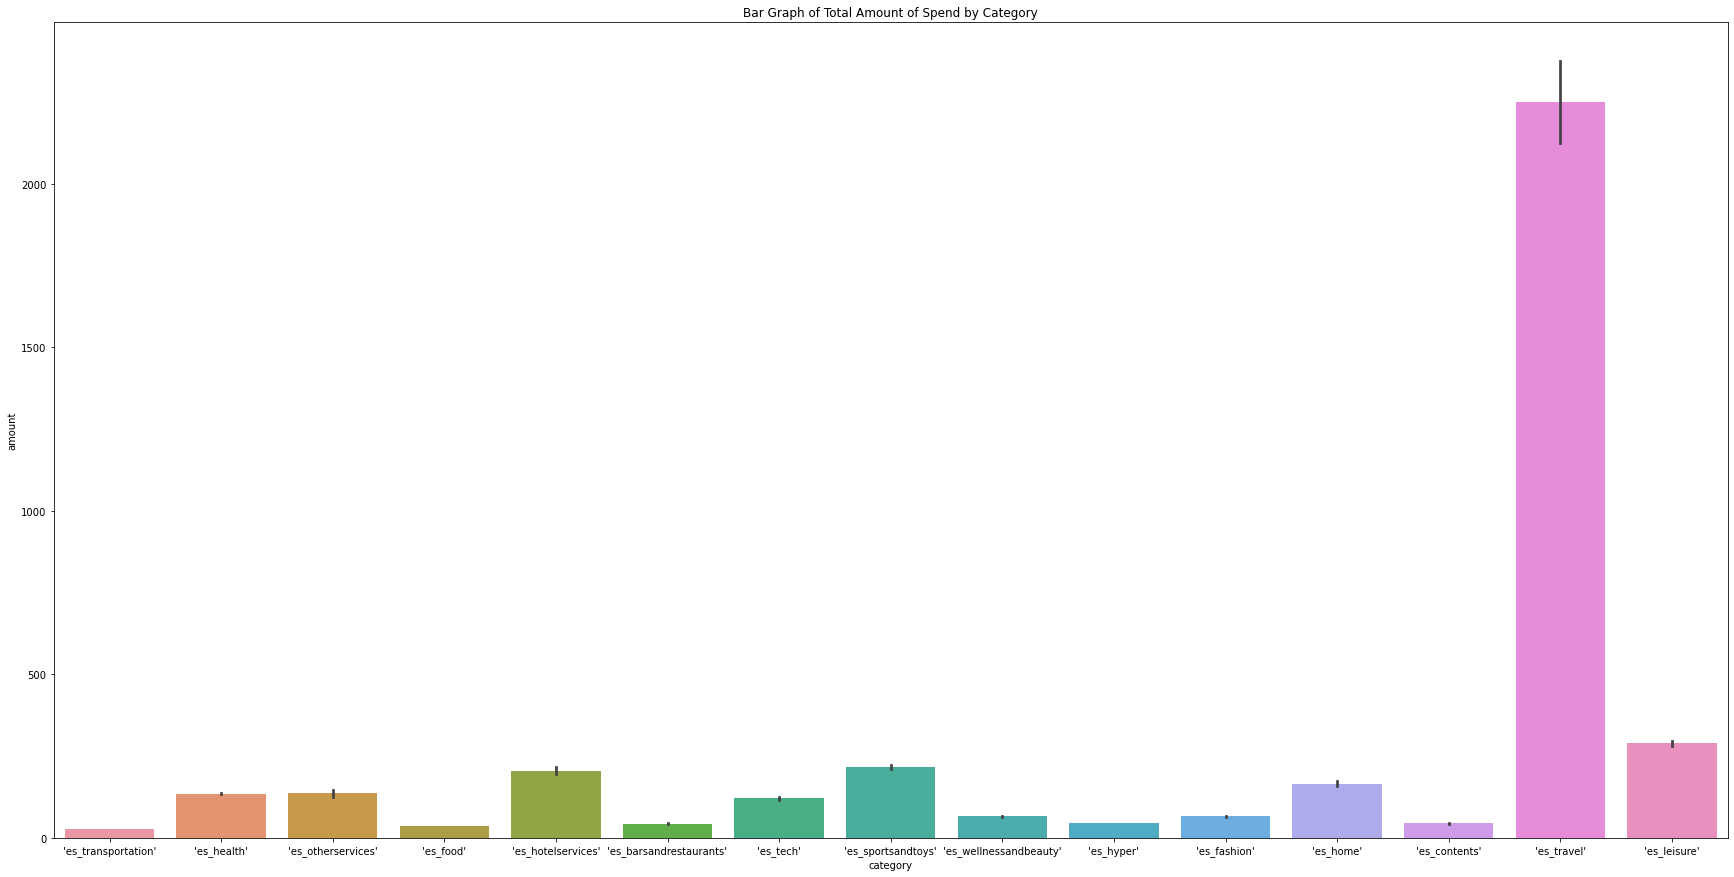

In [22]:
plt.figure(figsize=(30,15))
sns.barplot(x=bankdata_df.category,y=bankdata_df.amount)
plt.title("Bar Graph of Total Amount of Spend by Category")

plt.show()

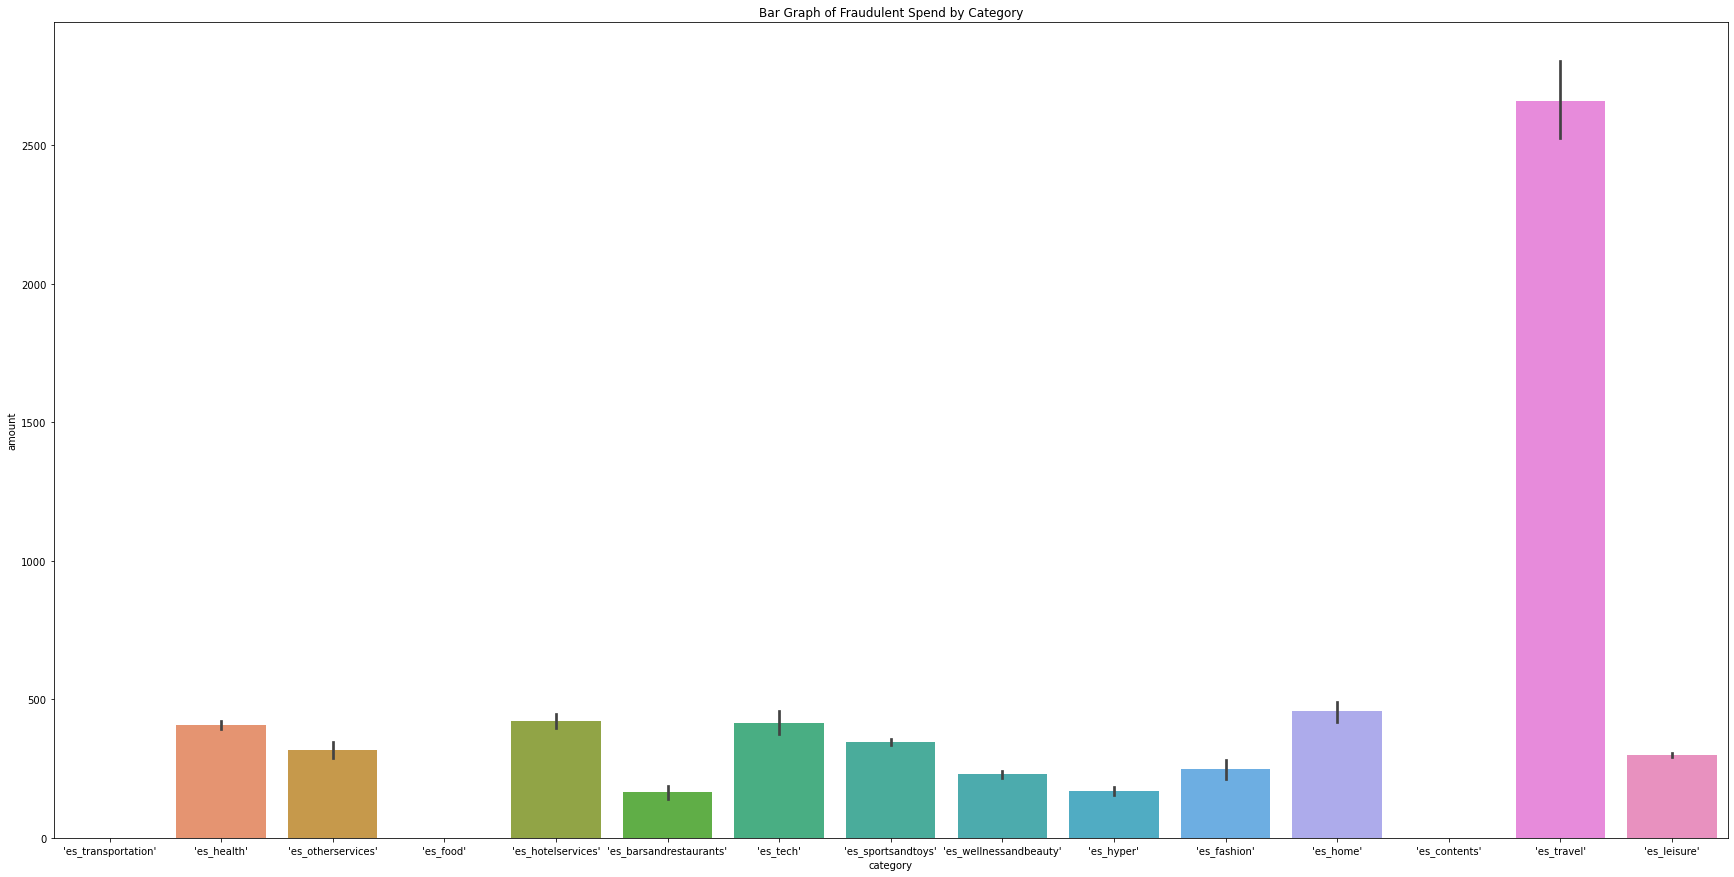

In [23]:
plt.figure(figsize=(30,15))
sns.barplot(x=bankdata_df.category,y=bankdata_df[bankdata_df['fraud']== 1].amount)
plt.title("Bar Graph of Fraudulent Spend by Category")

plt.show()

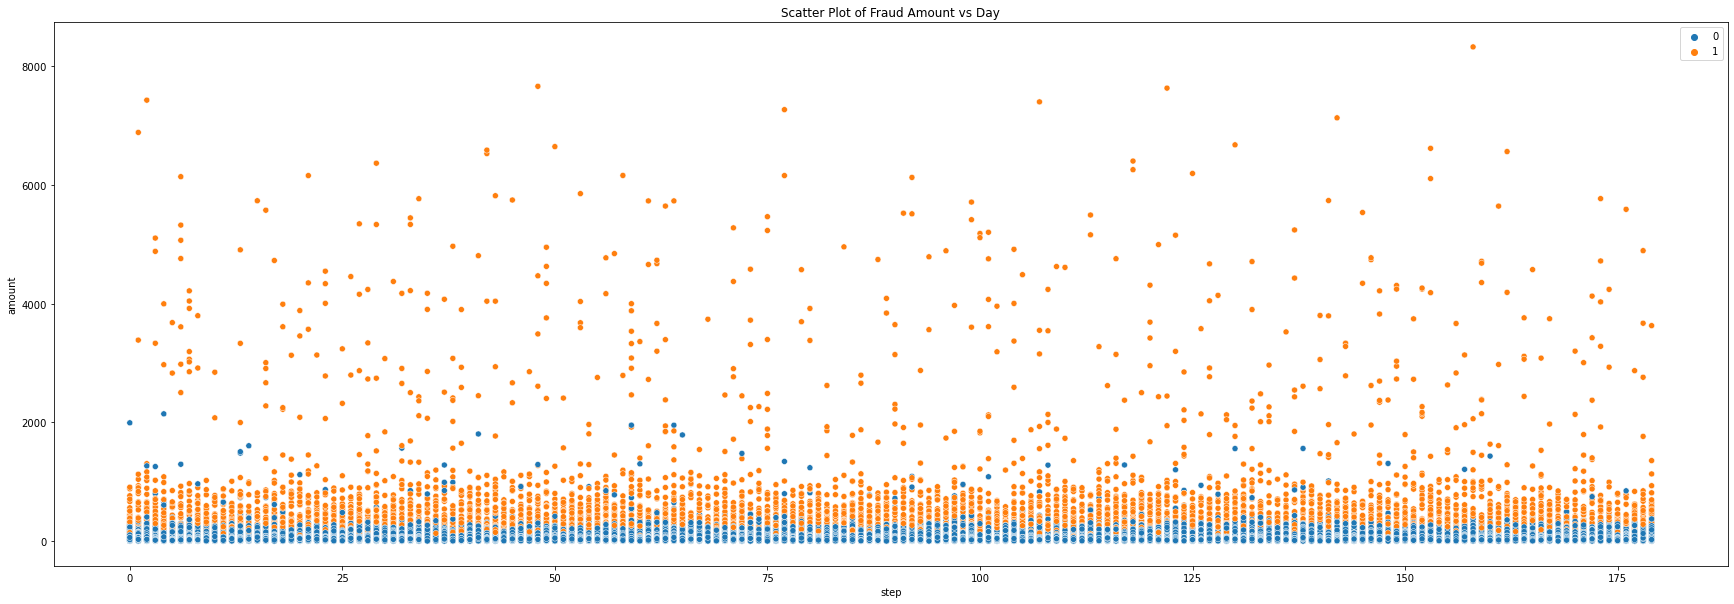

In [24]:
plt.figure(figsize=(30,10))
sns.scatterplot(x=bankdata_df.step,y=bankdata_df.amount,hue=bankdata_df.fraud)
plt.title("Scatter Plot of Fraud Amount vs Day")
plt.legend()
plt.show()

In [25]:
bankdata_df.describe()

,step,amount,fraud
count,594643.000000,594643.000000,594643.000000
mean,94.986827,37.890135,0.012108
std,51.053632,111.402831,0.109369
min,0.000000,0.000000,0.000000
25%,52.000000,13.740000,0.000000
50%,97.000000,26.900000,0.000000
75%,139.000000,42.540000,0.000000
max,179.000000,8329.960000,1.000000


In [26]:
bankdata_df['zipcodeOri'].value_counts()

KeyError: 'zipcodeOri'

In [ ]:
bankdata_df['zipMerchant'].value_counts()

Since there is only one zipcode and 1 merchant zipcode, I will remove these from the dataframe.

In [27]:
bankdata_df = bankdata_df.drop(columns=['zipcodeOri','zipMerchant'])

KeyError: "['zipcodeOri' 'zipMerchant'] not found in axis"

In [28]:
bankdata_df

,step,customer,age,gender,merchant,category,amount,fraud
0,0,'C1093826151','4','M','M348934600','es_transportation',4.55,0
1,0,'C352968107','2','M','M348934600','es_transportation',39.68,0
2,0,'C2054744914','4','F','M1823072687','es_transportation',26.89,0
3,0,'C1760612790','3','M','M348934600','es_transportation',17.25,0
4,0,'C757503768','5','M','M348934600','es_transportation',35.72,0
...,...,...,...,...,...,...,...,...
594638,179,'C1753498738','3','F','M1823072687','es_transportation',20.53,0
594639,179,'C650108285','4','F','M1823072687','es_transportation',50.73,0
594640,179,'C123623130','2','F','M349281107','es_fashion',22.44,0
594641,179,'C1499363341','5','M','M1823072687','es_transportation',14.46,0


In [29]:
bankdata_df['customer'].value_counts()

'C1978250683'    265
'C1275518867'    252
'C806399525'     237
'C515668508'     205
'C1338396147'    195
                ... 
'C1345586046'      6
'C1156745710'      6
'C1404665203'      5
'C1743702978'      5
'C1809646275'      5
Name: customer, Length: 4112, dtype: int64

## 2. Preprocessing the Data

In [30]:
col_categorical = bankdata_df.select_dtypes(include= ['object']).columns
for col in col_categorical:
    bankdata_df[col] = bankdata_df[col].astype('category')

    
bankdata_df[col_categorical] = bankdata_df[col_categorical].apply(lambda x: x.cat.codes)

In [31]:
bankdata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   step      594643 non-null  int64  
 1   customer  594643 non-null  int16  
 2   age       594643 non-null  int8   
 3   gender    594643 non-null  int8   
 4   merchant  594643 non-null  int8   
 5   category  594643 non-null  int8   
 6   amount    594643 non-null  float64
 7   fraud     594643 non-null  int64  
dtypes: float64(1), int16(1), int64(2), int8(4)
memory usage: 17.0 MB


In [32]:
subpipe_num = Pipeline(steps=[
    ('ss', StandardScaler())
])


subpipe_cat = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

CT = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_num, selector(dtype_include = np.number))
], remainder = 'passthrough')

In [33]:
X = bankdata_df.drop(['fraud'],axis=1)
y = bankdata_df['fraud']

In [34]:
X

,step,customer,age,gender,merchant,category,amount
0,0,210,4,2,30,12,4.55
1,0,2753,2,2,30,12,39.68
2,0,2285,4,1,18,12,26.89
3,0,1650,3,2,30,12,17.25
4,0,3585,5,2,30,12,35.72
...,...,...,...,...,...,...,...
594638,179,1639,3,1,18,12,20.53
594639,179,3369,4,1,18,12,50.73
594640,179,529,2,1,31,2,22.44
594641,179,1083,5,2,18,12,14.46


Due to there being so few examples of fraud, I have applied SMOTE below to increase the minority class to be at least 25% of the total population.

In [35]:
sm = SMOTE(random_state=42,sampling_strategy=.25)


In [36]:
X_smote, y_smote = sm.fit_resample(X, y)


In [37]:
X_smote

,step,customer,age,gender,merchant,category,amount
0,0,210,4,2,30,12,4.550000
1,0,2753,2,2,30,12,39.680000
2,0,2285,4,1,18,12,26.890000
3,0,1650,3,2,30,12,17.250000
4,0,3585,5,2,30,12,35.720000
...,...,...,...,...,...,...,...
734298,88,476,5,0,37,4,377.574268
734299,161,3925,3,1,30,4,46.632937
734300,52,1808,1,1,12,10,704.760427
734301,28,1249,3,1,21,7,172.614498


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state=42)

In [39]:
y_smote.value_counts()

0    587443
1    146860
Name: fraud, dtype: int64

Now the class is slightly more balanced, with 146,860 examples of the "Fraud" target (or 20% of the new population).

## 3. Modeling, Cross Validation and GridSearching

I use the cross validation class taken from FlatIron lecture 51, and then apply certain types of classifiers including:
    - Dummy classifier
    - Logistic Regression
    - KNN
    - Random Forest
    - GradientBoost Classifier

In [41]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)
    
    def cvmean(self):
        cvmean2 = round(self.cv_mean,3)
        print(cvmean2)

In [42]:
dummy_model_pipe = Pipeline(steps= [
    ('ct', CT),
    ('dum', DummyClassifier(strategy = 'most_frequent'))
])

dummy_pipe = ModelWithCV(dummy_model_pipe, 'dummy model', X_train, y_train)

In [43]:
dummy_pipe.print_cv_summary()

CV Results for `dummy model` model:
            0.80002 ± 0.00001 accuracy
        


In [44]:
logreg_model_pipe = Pipeline([
    ('ct', CT),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])

logreg_pipe = ModelWithCV(logreg_model_pipe,'logreg_model', X_train, y_train)
logreg_pipe.print_cv_summary()

CV Results for `logreg_model` model:
            0.95032 ± 0.00050 accuracy
        


In [45]:
knn_model_pipe = Pipeline([
    ('ct',CT),
    ('knn',KNeighborsClassifier())
])

knn_pipe = ModelWithCV(knn_model_pipe,'knn_model', X_train, y_train)
knn_pipe.print_cv_summary()

CV Results for `knn_model` model:
            0.98499 ± 0.00058 accuracy
        


In [46]:
rfc_model_pipe = Pipeline([
    ('ct',CT),
    ('rfc',RandomForestClassifier(random_state = 42))
])

rfc_pipe = ModelWithCV(rfc_model_pipe,'rfc_model', X_train, y_train)
rfc_pipe.print_cv_summary()

CV Results for `rfc_model` model:
            0.99397 ± 0.00027 accuracy
        


In [47]:
gbc_model_pipe = Pipeline([
    ('ct',CT),
    ('gbc',GradientBoostingClassifier(random_state = 42))
])

gbc_pipe = ModelWithCV(gbc_model_pipe,'gbc_model', X_train, y_train)
gbc_pipe.print_cv_summary()

CV Results for `gbc_model` model:
            0.97951 ± 0.00048 accuracy
        


### Apply Gridsearch to RFC and KNN, which had very high accuracy scores

In [48]:
#Tuning and Cross Validating of RFC. Here we add in some of the important selection criteria for RFC.

rfc_params = {}
rfc_params['rfc__criterion'] = ['gini','entropy']
rfc_params['rfc__min_samples_leaf'] = [1,5,10]
rfc_params['rfc__max_depth'] = [5,7,9]
rfc_params

knn_params = {}
knn_params['knn__n_neighbors']=[5,7,9]
knn_params['knn__weights']=['uniform','distance']
knn_params['knn__algorithm']='auto',
knn_params['knn__leaf_size']=[20,30]
knn_params['knn__p']=[1,2]
knn_params
    

{'knn__n_neighbors': [5, 7, 9],
 'knn__weights': ['uniform', 'distance'],
 'knn__algorithm': ('auto',),
 'knn__leaf_size': [20, 30],
 'knn__p': [1, 2]}

In [49]:
rfc_params

{'rfc__criterion': ['gini', 'entropy'],
 'rfc__min_samples_leaf': [1, 5, 10],
 'rfc__max_depth': [5, 7, 9]}

In [50]:
gs_rfc = GridSearchCV(rfc_model_pipe, rfc_params, cv=5, verbose=1)

In [51]:
gs_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 55.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000182C0FDCA60>)])),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_depth': [5, 7, 9],
                         'rfc__min_samples_leaf': [1, 5, 10]},
             verbose=1)

In [52]:
gs_rfc.best_params_

{'rfc__criterion': 'gini', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 5}

In [53]:
gs_rfc.best_score_

0.9821980752461255

In [54]:
pd.DataFrame(gs_rfc.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__criterion,param_rfc__max_depth,param_rfc__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,39.862725,11.747291,1.252087,0.407262,gini,5,1,"{'rfc__criterion': 'gini', 'rfc__max_depth': 5...",0.971801,0.972791,0.971229,0.972445,0.971274,0.971908,0.000623,13
1,28.568259,1.003996,0.993940,0.032396,gini,5,5,"{'rfc__criterion': 'gini', 'rfc__max_depth': 5...",0.971738,0.972636,0.971211,0.972355,0.971320,0.971852,0.000561,14
2,27.620189,0.198700,1.115003,0.182790,gini,5,10,"{'rfc__criterion': 'gini', 'rfc__max_depth': 5...",0.971801,0.972418,0.970920,0.972373,0.971238,0.971750,0.000598,15
3,35.701977,1.209477,1.176508,0.034894,gini,7,1,"{'rfc__criterion': 'gini', 'rfc__max_depth': 7...",0.977793,0.977639,0.976949,0.978274,0.977784,0.977688,0.000427,7
4,40.695359,7.890188,1.217694,0.270440,gini,7,5,"{'rfc__criterion': 'gini', 'rfc__max_depth': 7...",0.977539,0.977385,0.977403,0.978292,0.977157,0.977555,0.000388,8


In [127]:
# rfc_model_pipe = Pipeline([
#     ('ct',CT),
#     ('rfc',RandomForestClassifier(random_state = 42,max_depth=7))
# ])

# rfc_model_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000223306365B0>)])),
                ('rfc', RandomForestClassifier(max_depth=7, random_state=42))])

In [128]:
# rfc_model_pipe.score(X_train,y_train)

0.9776186749514733

In [129]:
# rfc_model_pipe.score(X_test,y_test)

0.9783359480542119

In [56]:
gs_knn = GridSearchCV(knn_model_pipe, knn_params, cv=5, verbose=1)

In [57]:
gs_knn.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 337.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000182C0FDCA60>)])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__algorithm': ('auto',),
                         'knn__leaf_size': [20, 30],
                         'knn__n_neighbors': [5, 7, 9], 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             verbose=1)

In [58]:
gs_knn.best_params_

{'knn__algorithm': 'auto',
 'knn__leaf_size': 20,
 'knn__n_neighbors': 5,
 'knn__p': 1,
 'knn__weights': 'distance'}

In [59]:
gs_knn.best_score_

0.9893504400219901

In [60]:
pd.DataFrame(gs_knn.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__algorithm,param_knn__leaf_size,param_knn__n_neighbors,param_knn__p,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,84.849764,3.203098,21.962827,0.520516,auto,20,5,1,uniform,"{'knn__algorithm': 'auto', 'knn__leaf_size': 2...",0.987090,0.987281,0.986763,0.987044,0.986581,0.986952,0.000248,9
1,84.179662,2.099566,21.130138,2.004131,auto,20,5,1,distance,"{'knn__algorithm': 'auto', 'knn__leaf_size': 2...",0.989360,0.989559,0.989323,0.989378,0.989133,0.989350,0.000136,1
2,78.889280,1.083485,23.096808,1.182774,auto,20,5,2,uniform,"{'knn__algorithm': 'auto', 'knn__leaf_size': 2...",0.984421,0.984829,0.984139,0.984257,0.983794,0.984288,0.000340,19
3,103.465765,18.456235,30.448208,16.974056,auto,20,5,2,distance,"{'knn__algorithm': 'auto', 'knn__leaf_size': 2...",0.987172,0.987308,0.986899,0.986917,0.986609,0.986981,0.000242,7
4,111.296050,27.812161,37.804413,9.368297,auto,20,7,1,uniform,"{'knn__algorithm': 'auto', 'knn__leaf_size': 2...",0.985501,0.985964,0.985610,0.985628,0.984920,0.985525,0.000340,15


In [61]:
import pickle
pickle.dump(rfc_model_pipe,open("rfc_fraud_model.sav",'wb'))

In [ ]:
pickle.dump(knn_model_pipe,open("knn_fraud_model.sav",'wb'))

In [130]:
y_hat1 = rfc_model_pipe.predict(X_test)

In [131]:
y_hat1

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [132]:
print(classification_report(y_test,y_hat1))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99    146849
           1       0.94      0.95      0.95     36727

    accuracy                           0.98    183576
   macro avg       0.96      0.97      0.97    183576
weighted avg       0.98      0.98      0.98    183576



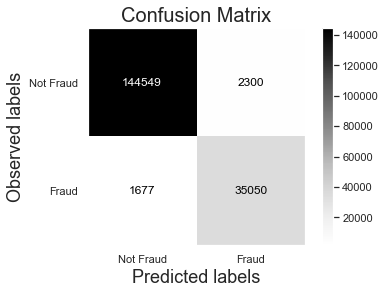

In [133]:
#Plot a confusion matric on actual and preditions of the test data.
ax = plt.subplot()
sns.set(font_scale=1) # Adjust to fit

plot_confusion_matrix(rfc_model_pipe, X_test, y_test, ax=ax,  cmap = plt.cm.Greys, display_labels=['Not Fraud','Fraud'])

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);
ax.grid(b=False);

title_font = {'size':'20'}  # Adjust to fit
ax.set_title('Confusion Matrix', fontdict=title_font);

plt.savefig('Confusion Matrix')

plt.show()

In [136]:
knn_model_pipe = Pipeline([
    ('ct',CT),
    ('knn',KNeighborsClassifier())
])

knn_model_pipe.fit(X_train,y_train)
knn_model_pipe.score(X_train,y_train)

0.9904090411401656

In [137]:
knn_model_pipe.score(X_test,y_test)

0.9862345840414869

In [138]:
y_hat_knn = knn_model_pipe.predict(X_test)

In [139]:
print(classification_report(y_test,y_hat_knn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    146849
           1       0.96      0.97      0.97     36727

    accuracy                           0.99    183576
   macro avg       0.98      0.98      0.98    183576
weighted avg       0.99      0.99      0.99    183576

